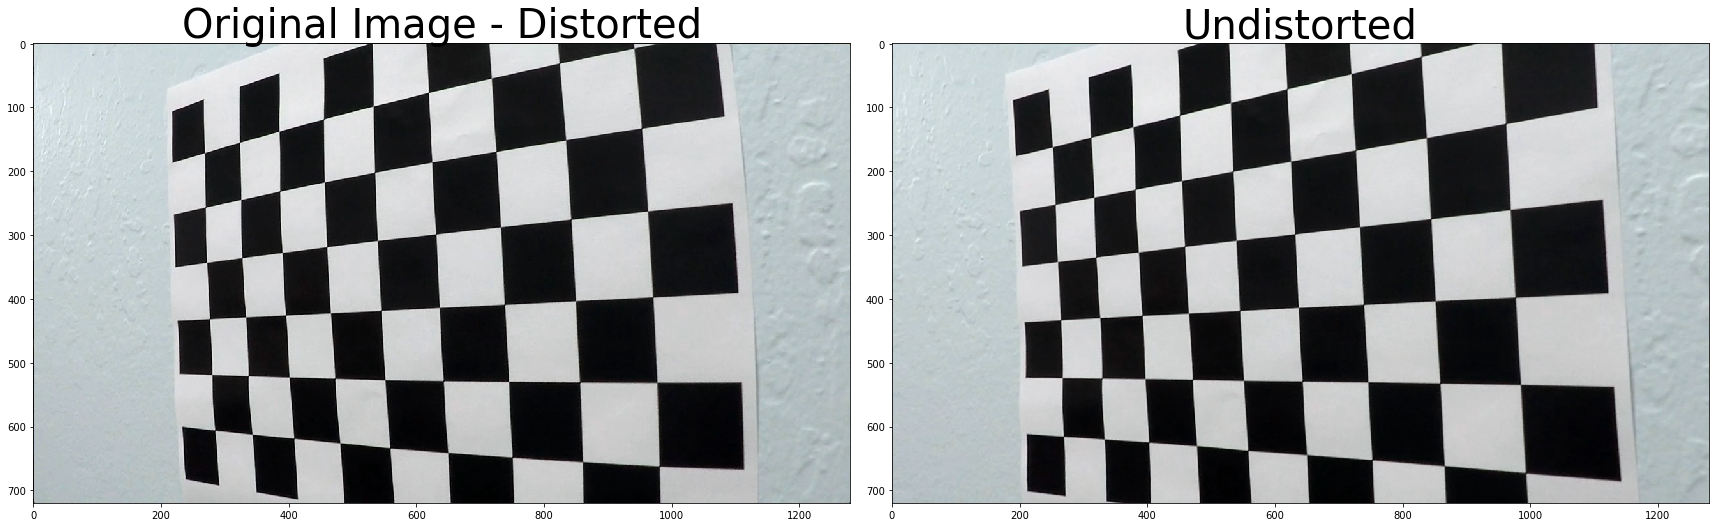

In [13]:
#Camera Calibration
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

images=glob.glob('camera_cal/calibration*.jpg')
img=cv2.imread('camera_cal/calibration4.jpg')

objpoints=[]#Object points
imgpoints=[]#Image points

objp=np.zeros((6*9,3),np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    image1=cv2.imread(fname)
    gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
# print(objp)
    
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
dst=cv2.undistort(img,mtx,dist,None,mtx)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(img)
axes[0].set_title('Original Image - Distorted', fontsize=40)
axes[1].imshow(dst)
axes[1].set_title('Undistorted', fontsize=40)

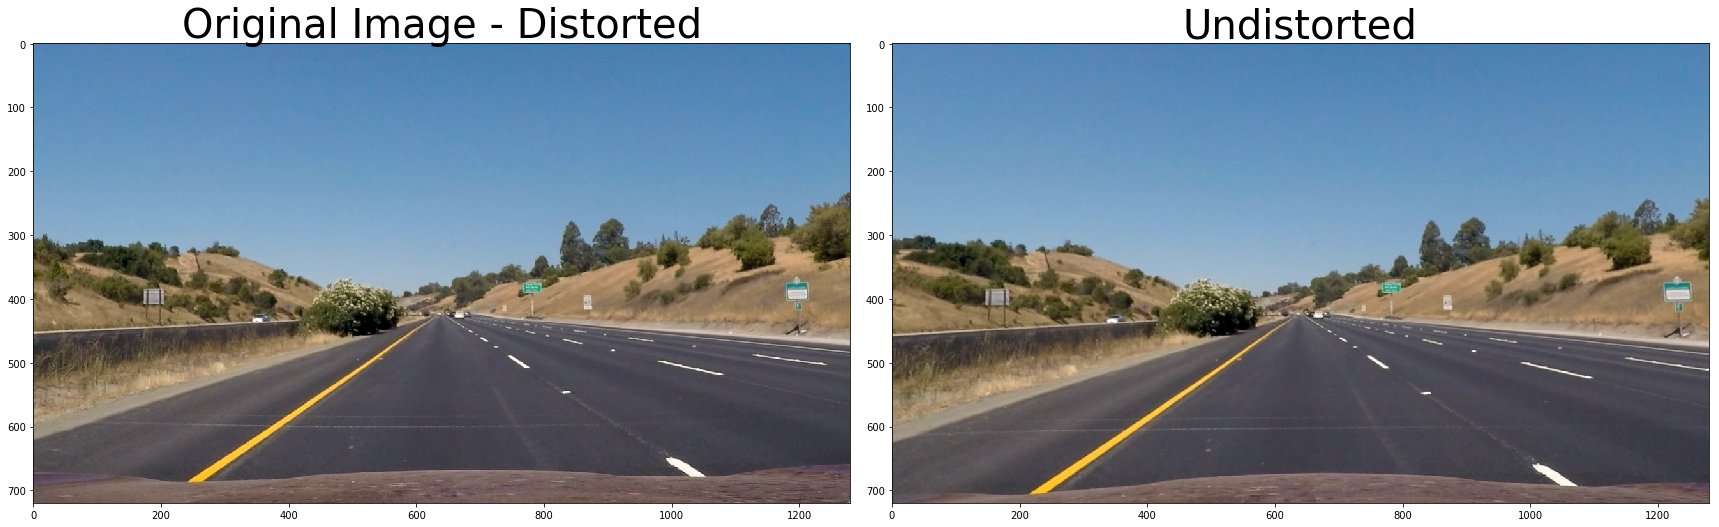

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
img1=mpimg.imread('test_images/straight_lines1.jpg')

dst1=cv2.undistort(img1,mtx,dist,None,mtx)
f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(img1)
axes[0].set_title('Original Image - Distorted', fontsize=40)
axes[1].imshow(dst1)
axes[1].set_title('Undistorted', fontsize=40)

(720, 1280)


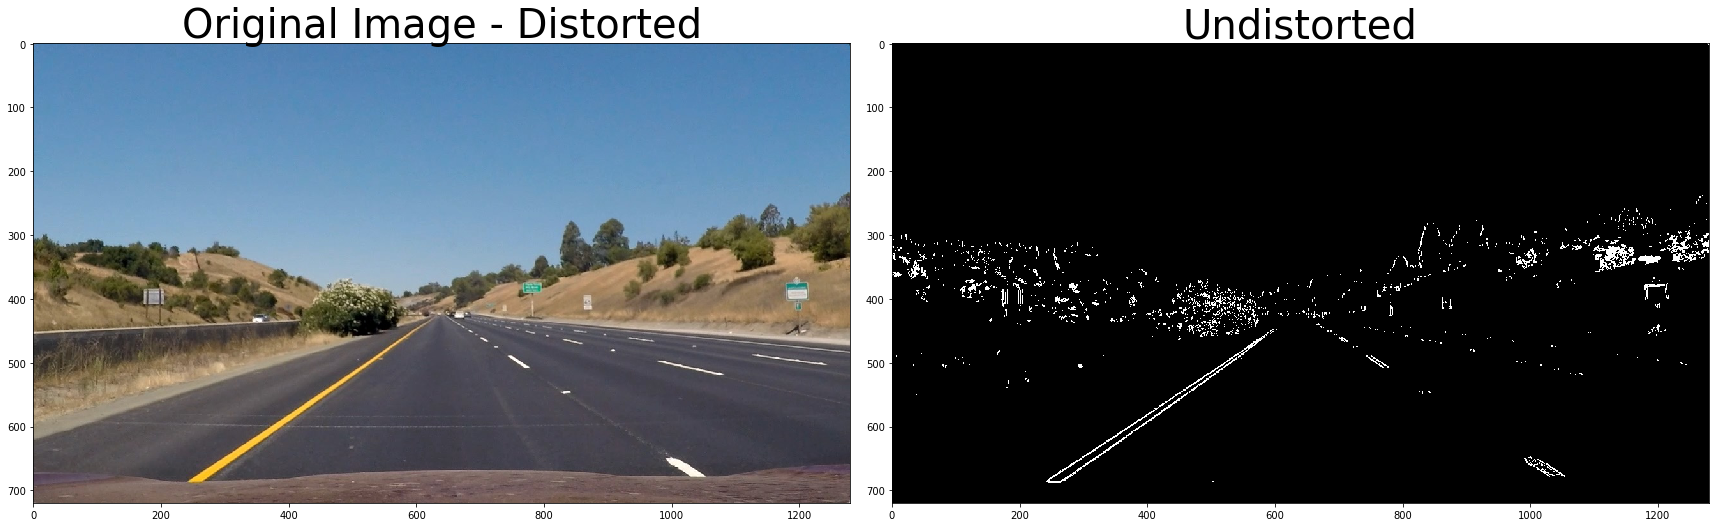

In [20]:
def sobel_conversion(img,thresh):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    gray1=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray1, cv2.CV_64F, 1, 0)
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    s=np.zeros_like(gray1)
#     s[(hls[:,:,1]>=thresh[0])&(hls[:,:,1]<thresh[1])|(scaled_sobel>=thresh1[0])&(scaled_sobel<thresh1[1])]=1
#     s[(hls[:,:,2]>=thresh[0])&(hls[:,:,2]<thresh[1])|(hls[:,:,1]>=thresh1[0])&(hls[:,:,1]<thresh1[1])]=1
    s[(hls[:,:,2]>thresh[0])&(hls[:,:,2]<=thresh[1])|(hls[:,:,1]>20)&(hls[:,:,1]<=25)|(scaled_sobel>60)&(scaled_sobel<=235)]=1
    s=np.uint8(s)
#     s=hls[:,:,2]
    return s

img1=mpimg.imread('test_images/straight_lines1.jpg')

color_thres=sobel_conversion(img1,[120,205]) 
f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(img1)
axes[0].set_title('Original Image - Distorted', fontsize=40)
axes[1].imshow(color_thres,cmap='gray')
axes[1].set_title('Undistorted', fontsize=40)

print(color_thres.shape)

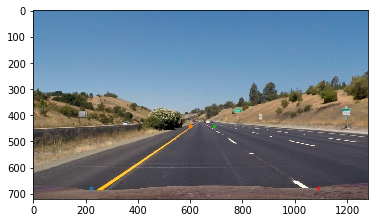

In [149]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
img=mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(img)
plt.plot(220,680,'.')
plt.plot(600,440,'.')
plt.plot(690,440,'.')
plt.plot(1090,680,'.')

In [184]:
#Lane finding
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# img=mpimg.imread('test_images/straight_lines1.jpg')

cap=cv2.VideoCapture('project_video.mp4')

def sobel_conversion(img,thresh):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    gray1=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray1, cv2.CV_64F, 1, 0)
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    s=np.zeros_like(gray1)
#     s[(hls[:,:,1]>=thresh[0])&(hls[:,:,1]<thresh[1])|(scaled_sobel>=thresh1[0])&(scaled_sobel<thresh1[1])]=1
#     s[(hls[:,:,2]>=thresh[0])&(hls[:,:,2]<thresh[1])|(hls[:,:,1]>=thresh1[0])&(hls[:,:,1]<thresh1[1])]=1
    s[(hls[:,:,2]>thresh[0])&(hls[:,:,2]<=thresh[1])|(hls[:,:,1]>20)&(hls[:,:,1]<=25)|(scaled_sobel>60)&(scaled_sobel<=235)]=1
    s=np.uint8(s)
#     s=hls[:,:,2]
    return s

def warp(img):
    img_size=(img.shape[1],img.shape[0])
    src=np.float32([[710,450],
                   [1090,680],
                   [220,680],
                   [580,450]])
    dest=np.float32([[1180,0],
                   [1180,720],
                   [100,720],
                   [100,0]])
    M=cv2.getPerspectiveTransform(src,dest)
    Minv=cv2.getPerspectiveTransform(dest,src)
    w=cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)    
    return w,Minv

# img=mpimg.imread('test_images/test5.jpg')
# dst=cv2.undistort(img,mtx,dist,None,mtx)
# s=sobel_conversion(dst,[190,240])
# w=warp(s)
# cv2.imshow('W',s)
i=1
#Checking with the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('video.mp4',fourcc,30.0,(1280,720))
while(cap.isOpened()):
    ret,frame=cap.read()
    img=frame
    udst=cv2.undistort(img,mtx,dist,None,mtx)
    w,Minv=warp(udst)
    s=sobel_conversion(w,[120,205]) 
#     print(s.shape)
    # print(s)
#     cv2.imshow('W',s*255)
    if i==1:
        histogram=np.sum(s[s.shape[0]//2:,:],axis=0)
        out_img = np.dstack((s, s, s))*255
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:])+midpoint
        nwindows = 9
        window_height = np.int(s.shape[0]/nwindows)
        nonzero = s.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 300
        left_lane_inds = []
        right_lane_inds = []
        img_size=(img.shape[1],img.shape[0])
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = s.shape[0] - (window+1)*window_height
            win_y_high = s.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
#             cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#             cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
#         print (left_fit)
#         print (right_fit)
#         plt.plot(histogram)
    i=i+1
    nonzero = s.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, s.shape[0]-1, s.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((s,s,s))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    line_pts1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_pts2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    line_pts = np.hstack((line_pts1, line_pts2))
    # Draw the lane onto the warped blank image 
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img,np.int_([line_pts]),(0,0,255))
    result = cv2.addWeighted(out_img, 1, window_img, 1.5, 0)
    lefto=cv2.warpPerspective(result,Minv,img_size,flags=cv2.INTER_LINEAR)
    result1 = cv2.addWeighted(img, 1, lefto, 0.3, 0)
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    mean_rad=float((left_curverad+right_curverad)/(2*1000))
    mean_rad=str.format("{0:.3f}", mean_rad) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result1,'Mean Radius: '+str(mean_rad)+'KM',(10,100), font, 1,(255,0,0),2,cv2.LINE_AA)
    cv2.imshow('Res',result1)
    video.write(result1)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
video.release()